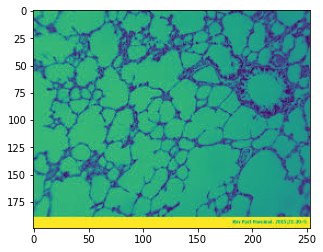

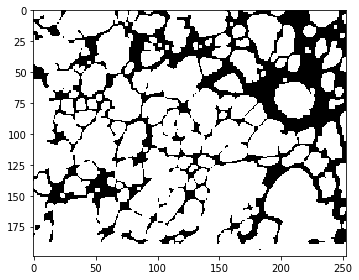

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage
from skimage import measure, color, io
import pandas
import sklearn
import numpy as np
from scipy import stats
from scipy.stats import norm

#STEP1 - Read image and define pixel size
img = cv2.imread("C:/Users/sanja/OneDrive/Pictures/lung.jpg", 0)
plt.imshow(img)
plt.show()

pixels_to_um = 0.5 # (1 px = 500 nm)

#cropped_img = img[0:450, :]   #Crop the scalebar region

#Step 2: Denoising, if required and threshold image

#No need for any denoising or smoothing as the image looks good.
#Otherwise, try Median or NLM
#plt.hist(img.flat, bins=100, range=(0,255))

#Change the grey image to binary by thresholding. 
ret, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
#print(ret)  #Gives 157 on grains2.jpg. OTSU determined this to be the best threshold. 

#View the thresh image. Some boundaries are ambiguous / faint.
#Some pixles in the middle. 
#Need to perform morphological operations to enhance.

#Step 3: Clean up image, if needed (erode, etc.) and create a mask for grains

kernel = np.ones((3,3),np.uint8) 
eroded = cv2.erode(thresh,kernel,iterations = 1)
dilated = cv2.dilate(eroded,kernel,iterations = 1)

# Now, we need to apply threshold, meaning convert uint8 image to boolean.
mask = dilated == 255  #Sets TRUE for all 255 valued pixels and FALSE for 0
#print(mask)   #Just to confirm the image is not inverted. 

#from skimage.segmentation import clear_border
#mask = clear_border(mask)   #Removes edge touching grains. 

io.imshow(mask)  #cv2.imshow() not working on boolean arrays so using io
#io.imshow(mask[250:280, 250:280])   #Zoom in to see pixelated binary image

#Step 4: Label grains in the masked image

#Now we have well separated grains and background. Each grain is like an object.
#The scipy ndimage package has a function 'label' that will number each object with a unique ID.

#The 'structure' parameter defines the connectivity for the labeling. 
#This specifies when to consider a pixel to be connected to another nearby pixel, 
#i.e. to be part of the same object.

#use 8-connectivity, diagonal pixels will be included as part of a structure
#this is ImageJ default but we have to specify this for Python, or 4-connectivity will be used
# 4 connectivity would be [[0,1,0],[1,1,1],[0,1,0]]
s = [[1,1,1],[1,1,1],[1,1,1]]
#label_im, nb_labels = ndimage.label(mask)
labeled_mask, num_labels = ndimage.label(mask, structure=s)

#The function outputs a new image that contains a different integer label 
#for each object, and also the number of objects found.


#Let's color the labels to see the effect
img2 = color.label2rgb(labeled_mask, bg_label=0)

#cv2.imshow('Colored Grains', img2)
#cv2.waitKey(0)

#View just by making mask=threshold and also mask = dilation (after morph operations)
#Some grains are well separated after morph operations

#Now each object had a unique number in the image. 
#Total number of labels found are...
#print(num_labels) 

#Step 5: Measure the properties of each grain (object)

# regionprops function in skimage measure module calculates useful parameters for each object.

clusters = measure.regionprops(labeled_mask, img)  #send in original image for Intensity measurements

#The output of the function is a list of object properties. 

#Test a few measurements
#print(clusters[0].perimeter)

#Can print various parameters for all objects
#for prop in clusters:
#    print('Label: {} Area: {}'.format(prop.label, prop.area))
    
#Step 6: Output results into a csv file   
#Best way is to output all properties to a csv file
    
propList = ['Area',
            'equivalent_diameter', #Added... verify if it works
            'orientation', #Added, verify if it works. Angle btwn x-axis and major axis.
            'MajorAxisLength',
            'MinorAxisLength',
            'Perimeter',
            'MinIntensity',
            'MeanIntensity',
            'MaxIntensity']   
#print(propList)
    

output_file = open('image_measurements.csv', 'w')
output_file.write(',' + ",".join(propList) + '\n') #join strings in array by commas, leave first cell blank
#First cell blank to leave room for header (column names)

for cluster_props in clusters:
    #output cluster properties to the excel file
    output_file.write(str(cluster_props['Label']))
    for i,prop in enumerate(propList):
        if(prop == 'Area'): 
            to_print = cluster_props[prop]*pixels_to_um**2   #Convert pixel square to um square
        elif(prop == 'orientation'): 
            to_print = cluster_props[prop]*57.2958  #Convert to degrees from radians
        elif(prop.find('Intensity') < 0):          # Any prop without Intensity in its name
            to_print = cluster_props[prop]*pixels_to_um
        else: 
            to_print = cluster_props[prop]     #Reamining props, basically the ones with Intensity in its name
        output_file.write(',' + str(to_print))
    output_file.write('\n')
output_file.close()   #Closes the file, otherwise it would be read only.


In [2]:
import pandas as pd
df = pd.read_csv ("image_measurements.csv", sep=',')
df.head()

,Unnamed: 0,Area,equivalent_diameter,orientation,MajorAxisLength,MinorAxisLength,Perimeter,MinIntensity,MeanIntensity,MaxIntensity
0,1,7556.00,98.084647,60.251138,141.808539,94.125551,2555.331222,116,166.795229,255
1,2,4.50,2.393654,-87.400018,3.708361,1.519798,6.810660,122,155.666667,174
2,3,314.25,20.002888,82.016322,31.674791,19.850730,145.790368,116,154.476531,190
3,4,10.00,3.568248,35.471386,4.024718,3.277064,10.828427,121,145.100000,160
4,5,6.00,2.763953,88.221106,5.377246,1.434382,9.207107,123,148.250000,168
